In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sb
import matplotlib.pyplot as plt

# Importing the required packages
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [4]:
nums=['ㄱ','ㄴ','ㄷ','ㄹ','ㅁ','ㅂ','ㅅ','ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ']
j=0
for num in nums:
    path = '../data/자음/jy/%s.csv'%num
    num = pd.read_csv(path, engine='python', encoding='cp949')
    num.columns =["aX", "aY", "aZ", "gX","gY","gZ",'little','ring','middle','index','thumb']
    #num.drop(['aX','aY','aZ','gX','gY','gZ'], axis=1, inplace=True)
    data = num
    
    for k in data.columns:     #data.columns[w:] if you have w column of line description 
        data[k] = data[k].fillna(data[k].median())
    #data = data.filter(['little','ring','middle','index','thumb'])
    data.insert(11,'Character',j)
    j=j+1
    #finaldata = pd.concat([finaldata, data], sort=False, ignore_index=True)
   
    print(data)
#print(num)

       aX    aY    aZ     gX     gY     gZ  little  ring  middle  index  \
0    0.43  0.86  0.31  10.31  -3.91   4.21     264   312     224    472   
1    0.46  0.85  0.27  20.45   1.83   4.94     268   307     226    466   
2    0.36  0.92  0.24  29.36  14.71 -26.12     268   310     226    458   
3    0.31  0.95  0.24 -15.20 -14.53   1.59     269   314     227    470   
4    0.36  0.93  0.23  -2.99  -6.10   0.43     270   302     228    470   
..    ...   ...   ...    ...    ...    ...     ...   ...     ...    ...   
649 -0.04 -0.31  1.09 -22.09  36.25 -15.20     423   521     402    446   
650  0.09 -0.23  0.98  -1.28   5.74 -13.24     409   511     388    426   
651 -0.04 -0.29  0.99   1.89   1.71 -10.13     399   511     387    433   
652 -0.00 -0.28  0.98   0.61  -1.40  -3.85     399   511     389    434   
653 -0.03 -0.27  0.98   0.43  -2.01  -2.50     394   509     389    435   

     thumb  Character  
0      418          0  
1      413          0  
2      416          0  
3  

       aX    aY    aZ     gX     gY     gZ  little  ring  middle  index  \
0    0.46  0.89  0.20 -11.54  18.86  -0.67     261   456     430    478   
1    0.32  0.81  0.30  15.56  -2.38   8.36     264   457     425    474   
2    0.43  0.89  0.32   1.22 -13.31   3.97     267   456     422    477   
3    0.40  0.78  0.43 -57.01  34.42 -20.02     295   458     427    475   
4    0.47  0.75  0.36  -1.16 -18.68 -14.10     267   454     426    475   
..    ...   ...   ...    ...    ...    ...     ...   ...     ...    ...   
509  0.31  0.87  0.39  -2.50  -3.60  -3.17     316   464     423    479   
510  0.30  0.88  0.40  -9.64  -7.39  -2.56     308   455     426    486   
511  0.29  0.86  0.42   2.14  -3.85  -1.40     308   459     424    479   
512  0.26  0.90  0.44  -7.08  -2.56  -4.76     310   462     422    475   
513  0.29  0.89  0.47  -9.83  -4.52  -0.31     314   463     428    474   

     thumb  Character  
0      431          9  
1      433          9  
2      434          9  
3  

In [33]:
nums=['ㄱ','ㄴ','ㄷ','ㄹ','ㅁ','ㅂ','ㅅ','ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ']
finaldata_jy = pd.DataFrame(columns=(['aX', 'aY', 'aZ', 'gX','gY','gZ','index','middle','ring','little','thumb']))
j=0
for num in nums:
    path = '../data/자음/jy/%s.csv'%num
    num_jy = pd.read_csv(path, engine='python', encoding='cp949')
    num_jy.columns =['aX', 'aY', 'aZ', 'gX','gY','gZ','little','ring','middle','index','thumb']
    data_jy = num_jy
    
    for k in data_jy.columns:     #data.columns[w:] if you have w column of line description 
        data_jy[k] = data_jy[k].fillna(data_jy[k].median())
    data_jy = data_jy.filter(['aX', 'aY', 'aZ', 'gX','gY','gZ','little','ring','middle','index','thumb'])
    data_jy.insert(11,'Character',j)
    j=j+1
    finaldata_jy = pd.concat([finaldata_jy,data_jy[180:]],sort=False,ignore_index = True)
    test_jy = data_jy[:149]
    test_jy=test_jy.drop("Character", axis = 1)
    #print(finaldata)
#finaldata.isnull().any()
finaldata_jy = finaldata_jy.astype({'Character':int})
finaldata_jy

,aX,aY,aZ,gX,gY,gZ,index,middle,ring,little,thumb,Character
0,0.38,0.87,0.31,1.71,-2.14,-3.48,472,236,322,252,438,0
1,0.38,0.87,0.31,-2.44,-3.23,3.11,475,237,320,253,438,0
2,0.42,0.87,0.32,-0.06,-3.23,-2.32,475,239,318,251,432,0
3,0.40,0.86,0.30,-1.22,-3.23,-1.59,472,240,322,252,438,0
4,0.38,0.86,0.32,5.43,-3.11,-1.40,476,236,320,250,436,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4705,0.68,-0.66,0.35,0.49,-2.56,-2.81,300,223,313,252,401,13
4706,0.68,-0.66,0.36,-0.92,-3.36,-2.99,298,219,310,252,400,13
4707,0.68,-0.66,0.36,1.65,-2.44,-2.08,303,218,314,255,402,13
4708,0.68,-0.65,0.36,-2.81,-4.03,-2.62,301,222,311,251,400,13


In [35]:
test_jy

,aX,aY,aZ,gX,gY,gZ,little,ring,middle,index,thumb
0,0.72,-0.72,0.13,-1.89,3.97,16.05,235,280,193,275,389
1,0.39,-0.91,0.04,-28.20,-27.83,-5.25,228,279,194,277,392
2,0.61,-0.75,0.25,17.52,15.93,-8.48,236,284,194,276,391
3,0.60,-0.79,0.00,5.86,-1.59,-1.71,232,282,198,278,390
4,0.56,-0.82,0.12,3.23,0.73,6.16,230,286,200,280,388
...,...,...,...,...,...,...,...,...,...,...,...
144,0.56,-0.71,0.47,0.31,-2.75,-1.71,243,308,213,299,385
145,0.55,-0.71,0.46,-2.44,-3.72,-2.14,246,306,213,292,386
146,0.55,-0.72,0.43,-2.08,-3.72,-2.01,244,304,215,296,384
147,0.54,-0.73,0.45,0.24,-7.57,1.95,243,306,216,298,386


In [36]:
nums=['ㄱ','ㄴ','ㄷ','ㄹ','ㅁ','ㅂ','ㅅ','ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ']
finaldata_yj = pd.DataFrame(columns=(['aX', 'aY', 'aZ', 'gX','gY','gZ','index','middle','ring','little','thumb']))
j=0
for num in nums:
    path = '../data/자음/yj/%s.csv'%num
    num_yj = pd.read_csv(path, engine='python', encoding='cp949')
    num_yj.columns =['aX', 'aY', 'aZ', 'gX','gY','gZ','little','ring','middle','index','thumb']
    data_yj = num_yj
    
    for k in data_yj.columns:     #data.columns[w:] if you have w column of line description 
        data_yj[k] = data_yj[k].fillna(data_yj[k].median())
    data_yj = data_yj.filter(['aX', 'aY', 'aZ', 'gX','gY','gZ','little','ring','middle','index','thumb'])
    data_yj.insert(11,'Character',j)
    j=j+1
    finaldata_yj = pd.concat([finaldata_yj,data_yj[150:]],sort=False,ignore_index = True)
    test_yj = data_yj[:149]
    test_yj= test_yj.drop("Character", axis = 1)
    #print(finaldata_yj)
#finaldata.isnull().any()
finaldata_yj = finaldata_yj.astype({'Character':int})
finaldata_yj

,aX,aY,aZ,gX,gY,gZ,index,middle,ring,little,thumb,Character
0,0.52,0.72,0.42,2.08,-1.95,-5.86,322,247,468,418,238,0
1,0.53,0.78,0.41,0.24,-3.30,-0.85,320,244,464,414,235,0
2,0.55,0.75,0.42,4.27,-4.46,0.06,319,246,463,419,235,0
3,0.57,0.71,0.40,-2.50,-2.93,-0.85,320,247,468,419,237,0
4,0.56,0.71,0.44,0.55,-5.00,-4.09,317,244,462,420,234,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0.93,-0.38,-0.13,3.30,-3.36,-2.38,283,235,312,388,214,13
4932,0.92,-0.38,-0.12,1.59,-3.11,-2.62,295,235,316,385,211,13
4933,0.91,-0.38,-0.12,0.55,-2.32,-2.44,285,234,314,387,210,13
4934,0.91,-0.38,-0.13,-0.55,-3.72,-1.34,285,235,316,385,209,13


In [37]:
test_yj

,aX,aY,aZ,gX,gY,gZ,little,ring,middle,index,thumb
0,0.96,-0.29,-0.04,2.62,-4.82,0.55,401,295,222,271,196
1,0.94,-0.30,-0.06,0.18,-4.82,-2.62,403,295,220,271,194
2,0.97,-0.31,-0.06,-0.61,-2.87,-3.66,395,287,218,272,195
3,0.95,-0.31,-0.04,0.61,-0.61,-0.55,396,292,221,270,194
4,0.91,-0.33,-0.03,2.38,-3.85,-5.74,401,289,218,269,197
...,...,...,...,...,...,...,...,...,...,...,...
144,0.79,-0.42,-0.11,3.17,-10.99,1.10,391,301,227,279,200
145,0.93,-0.45,-0.16,-4.33,-1.16,-6.84,389,303,223,281,218
146,0.88,-0.45,-0.16,1.34,-0.61,-0.67,386,300,228,278,205
147,0.85,-0.46,-0.16,-0.24,0.06,-5.68,390,303,227,277,205


In [85]:
nums=['ㄱ','ㄴ','ㄷ','ㄹ','ㅁ','ㅂ','ㅅ','ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ']
finaldata_nh = pd.DataFrame(columns=(['aX', 'aY', 'aZ', 'gX','gY','gZ','index','middle','ring','little','thumb']))
j=0
for num in nums:
    path = '../data/자음/nh/%s.csv'%num
    num_nh = pd.read_csv(path, engine='python', encoding='cp949')
    num_nh.columns =['aX', 'aY', 'aZ', 'gX','gY','gZ','little','ring','middle','index','thumb']
    data_nh = num_nh
    
    for k in data_nh.columns:     #data.columns[w:] if you have w column of line description 
        data_nh[k] = data_nh[k].fillna(data_nh[k].median())
    data_nh = data_nh.filter(['aX', 'aY', 'aZ', 'gX','gY','gZ','little','ring','middle','index','thumb'])
    data_nh.insert(11,'Character',j)
    j=j+1
    
    finaldata_nh = pd.concat([finaldata_nh,data_nh[150:]],sort=False,ignore_index = True)
    test_nh = data_nh[:149]
    test_nh= test_nh.drop("Character", axis = 1)
    
    #print(finaldata_nh)
#finaldata.isnull().any()

finaldata_nh = finaldata_nh.astype({'Character':int})
finaldata_nh

,aX,aY,aZ,gX,gY,gZ,index,middle,ring,little,thumb,Character
0,0.29,0.91,0.08,5.49,9.22,-6.29,287,236,469,428,237,0
1,0.29,0.99,0.05,3.11,-1.83,0.12,289,237,473,426,239,0
2,0.27,0.93,0.10,-1.46,5.07,1.83,289,235,464,425,239,0
3,0.30,0.94,0.08,4.70,-4.88,-0.85,287,236,473,426,237,0
4,0.30,0.94,0.06,-0.98,-4.76,0.12,290,235,469,427,239,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5044,0.81,-0.53,0.30,0.85,-2.93,-2.81,276,222,305,397,229,13
5045,0.81,-0.52,0.31,-1.04,-2.99,-2.50,276,221,309,394,227,13
5046,0.80,-0.52,0.30,0.79,-3.23,-2.93,281,219,313,397,226,13
5047,0.80,-0.52,0.31,0.98,-3.05,-2.99,275,220,313,393,226,13


In [86]:
test_nh

,aX,aY,aZ,gX,gY,gZ,little,ring,middle,index,thumb
0,0.93,-0.33,0.19,0.67,-2.99,-2.20,400,297,211,269,221
1,0.93,-0.33,0.20,0.31,-3.42,-2.50,405,296,224,265,215
2,0.93,-0.33,0.20,0.61,-3.05,-2.62,406,297,212,268,221
3,0.93,-0.33,0.20,0.31,-2.50,-2.75,403,300,207,269,220
4,0.93,-0.33,0.20,0.43,-2.99,-2.26,402,294,210,270,220
...,...,...,...,...,...,...,...,...,...,...,...
144,0.67,-0.71,0.23,-6.16,27.16,-15.69,395,302,213,271,224
145,0.68,-0.69,0.28,-10.74,-3.85,-2.99,397,306,218,273,221
146,0.65,-0.71,0.25,-9.58,-7.20,-3.54,400,301,214,270,220
147,0.69,-0.71,0.19,-13.24,-8.61,-6.71,405,299,214,265,219


In [84]:
finaldata = pd.concat([finaldata_jy,finaldata_nh,finaldata_yj],sort=False,ignore_index = True)
finaldata = finaldata.astype({'Character':int})
finaldata

,aX,aY,aZ,gX,gY,gZ,index,middle,ring,little,thumb,Character
0,0.38,0.87,0.31,1.71,-2.14,-3.48,472,236,322,252,438,0
1,0.38,0.87,0.31,-2.44,-3.23,3.11,475,237,320,253,438,0
2,0.42,0.87,0.32,-0.06,-3.23,-2.32,475,239,318,251,432,0
3,0.40,0.86,0.30,-1.22,-3.23,-1.59,472,240,322,252,438,0
4,0.38,0.86,0.32,5.43,-3.11,-1.40,476,236,320,250,436,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14690,0.93,-0.38,-0.13,3.30,-3.36,-2.38,283,235,312,388,214,13
14691,0.92,-0.38,-0.12,1.59,-3.11,-2.62,295,235,316,385,211,13
14692,0.91,-0.38,-0.12,0.55,-2.32,-2.44,285,234,314,387,210,13
14693,0.91,-0.38,-0.13,-0.55,-3.72,-1.34,285,235,316,385,209,13


In [161]:
temp=[]
for i in range(447):
    temp.append(random.randint(0, 14))

In [164]:
temp = np.array(temp)

In [166]:
test["Character"] = temp

In [167]:
test

,aX,aY,aZ,gX,gY,gZ,little,ring,middle,index,thumb,Character
0,0.72,-0.72,0.13,-1.89,3.97,16.05,235,280,193,275,389,5
1,0.39,-0.91,0.04,-28.20,-27.83,-5.25,228,279,194,277,392,14
2,0.61,-0.75,0.25,17.52,15.93,-8.48,236,284,194,276,391,9
3,0.60,-0.79,0.00,5.86,-1.59,-1.71,232,282,198,278,390,13
4,0.56,-0.82,0.12,3.23,0.73,6.16,230,286,200,280,388,1
...,...,...,...,...,...,...,...,...,...,...,...,...
442,0.79,-0.42,-0.11,3.17,-10.99,1.10,391,301,227,279,200,6
443,0.93,-0.45,-0.16,-4.33,-1.16,-6.84,389,303,223,281,218,9
444,0.88,-0.45,-0.16,1.34,-0.61,-0.67,386,300,228,278,205,7
445,0.85,-0.46,-0.16,-0.24,0.06,-5.68,390,303,227,277,205,13


In [135]:
test = test.drop("Character",axis = 1)
test

,aX,aY,aZ,gX,gY,gZ,little,ring,middle,index,thumb
0,0.72,-0.72,0.13,-1.89,3.97,16.05,235,280,193,275,389
1,0.39,-0.91,0.04,-28.20,-27.83,-5.25,228,279,194,277,392
2,0.61,-0.75,0.25,17.52,15.93,-8.48,236,284,194,276,391
3,0.60,-0.79,0.00,5.86,-1.59,-1.71,232,282,198,278,390
4,0.56,-0.82,0.12,3.23,0.73,6.16,230,286,200,280,388
...,...,...,...,...,...,...,...,...,...,...,...
442,0.79,-0.42,-0.11,3.17,-10.99,1.10,391,301,227,279,200
443,0.93,-0.45,-0.16,-4.33,-1.16,-6.84,389,303,223,281,218
444,0.88,-0.45,-0.16,1.34,-0.61,-0.67,386,300,228,278,205
445,0.85,-0.46,-0.16,-0.24,0.06,-5.68,390,303,227,277,205


In [168]:
x = pd.concat([finaldata,test],sort=False, ignore_index=True)
x = finaldata.drop("Character", axis = 1)
y = finaldata["Character"].copy()

In [169]:
x

,aX,aY,aZ,gX,gY,gZ,index,middle,ring,little,thumb
0,0.38,0.87,0.31,1.71,-2.14,-3.48,472,236,322,252,438
1,0.38,0.87,0.31,-2.44,-3.23,3.11,475,237,320,253,438
2,0.42,0.87,0.32,-0.06,-3.23,-2.32,475,239,318,251,432
3,0.40,0.86,0.30,-1.22,-3.23,-1.59,472,240,322,252,438
4,0.38,0.86,0.32,5.43,-3.11,-1.40,476,236,320,250,436
...,...,...,...,...,...,...,...,...,...,...,...
14690,0.93,-0.38,-0.13,3.30,-3.36,-2.38,283,235,312,388,214
14691,0.92,-0.38,-0.12,1.59,-3.11,-2.62,295,235,316,385,211
14692,0.91,-0.38,-0.12,0.55,-2.32,-2.44,285,234,314,387,210
14693,0.91,-0.38,-0.13,-0.55,-3.72,-1.34,285,235,316,385,209


In [170]:
clf.feature_importances_

array([0.12577388, 0.16231945, 0.05290366, 0.00167436, 0.00173584,
       0.00160569, 0.16469938, 0.15757481, 0.13353254, 0.09623314,
       0.10194725])

In [171]:
pd.Series(y).value_counts()

0     1190
10    1071
12    1052
6     1051
3     1050
1     1041
9     1038
2     1034
7     1033
13    1030
5     1029
8     1028
11    1024
4     1024
Name: Character, dtype: int64

In [172]:
pd.Series(y_valid).value_counts()

0     119
10    107
3     105
6     105
12    105
1     104
2     104
9     104
4     103
5     103
7     103
8     103
13    103
11    102
Name: Character, dtype: int64

In [173]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

clf = ExtraTreesClassifier(n_estimators=3000, n_jobs=-1, random_state=42)

In [174]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, shuffle=True, stratify=y, random_state=42)

In [175]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

cross_val_score_array1 = cross_val_score(clf, x, y, cv=10, scoring="accuracy")
print(cross_val_score_array1)
print("acc/t", np.mean(cross_val_score_array1))
print("acc-stdev/t", cross_val_score_array1.std())

[0.97142857 0.99795918 0.98231293 0.99455782 1.         0.99523485
 0.98570456 0.99523485 0.99931926 0.99115044]
acc/t 0.9912902478894893
acc-stdev/t 0.008560925390698464


In [176]:
clf.fit(x_train, y_train)
pred = clf.predict(x_valid)

In [177]:
pred = clf.predict(x_valid)

In [148]:
clf

ExtraTreesClassifier(n_estimators=3000, n_jobs=-1, random_state=42)

In [147]:
x_valid

,aX,aY,aZ,gX,gY,gZ,index,middle,ring,little,thumb
4257,-0.04,-0.99,0.19,-1.22,-3.30,-3.54,283,212,279,250,290
3477,0.19,0.78,0.59,2.75,-3.78,-1.28,376,420,369,291,424
5280,0.85,-0.38,0.38,-0.18,-3.17,-1.71,290,246,469,429,219
7167,0.27,0.90,0.35,1.04,-3.85,-3.11,277,390,457,331,236
13757,0.83,-0.34,0.44,0.61,-2.14,-2.38,471,419,454,343,265
...,...,...,...,...,...,...,...,...,...,...,...
655,0.95,-0.33,-0.07,1.10,-2.08,-2.93,476,238,316,256,425
6123,0.84,-0.37,0.47,0.06,-3.11,-2.38,465,417,454,329,229
9879,0.49,0.76,0.42,0.67,-2.50,-2.50,326,250,470,414,237
12840,0.17,0.65,0.76,0.55,-3.91,-2.62,365,385,440,416,251


In [178]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       104
           2       1.00      1.00      1.00       104
           3       1.00      1.00      1.00       105
           4       1.00      1.00      1.00       103
           5       1.00      1.00      1.00       103
           6       1.00      1.00      1.00       105
           7       1.00      1.00      1.00       103
           8       1.00      1.00      1.00       103
           9       1.00      1.00      1.00       104
          10       1.00      1.00      1.00       107
          11       1.00      1.00      1.00       102
          12       1.00      1.00      1.00       105
          13       1.00      1.00      1.00       103

    accuracy                           1.00      1470
   macro avg       1.00      1.00      1.00      1470
weighted avg       1.00      1.00      1.00      1470



In [179]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_valid, pred))

1.0


In [180]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(clf, x_train, y_train, cv=10)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[1070,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0,
           0,    0,    0],
       [   0,  937,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,  930,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,  945,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,  920,    0,    0,    0,    0,    0,    0,
           0,    1,    0],
       [   0,    0,    0,    0,    0,  926,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   2,    0,    0,    0,    0,    0,  944,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,  930,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,  925,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  934,    0,
           0,    

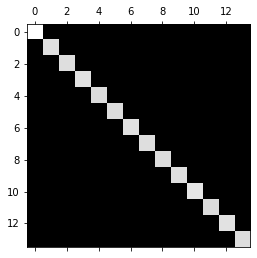

In [181]:
import matplotlib.pyplot as plt
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()
#표준편차